<a href="https://colab.research.google.com/github/BluBloos/3D-Hand-Tracking/blob/main/src/HandTracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

## Run ONLY when in Colab

In [ ]:
!echo "Initializing github repository"
!ls -la
!rm -r .config/
!rm -r sample_data/
!git clone https://github.com/BluBloos/QMIND2021-2022/ .

## Always Run

In [1]:
!git pull # Download updated project from Github.

##### HANDLE DIFFS WHEN RUNNING IN COLAB #####
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print("In Colab:", IN_COLAB)
import sys
if (IN_COLAB):
  sys.path.insert(1, '/content/src/')
##### HANDLE DIFFS WHEN RUNNING IN COLAB #####

######### EXTERNAL LIBRARIES #########
import os
import pickle
import matplotlib.pyplot as plt
import imageio
import numpy as np
import time
import tensorflow as tf
#NOTE: Good resource. -> https://www.tensorflow.org/tutorials/quickstart/advanced
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, MaxPool2D
from tensorflow.keras import Model
print("TensorFlow version:", tf.__version__)
import random
from qmindcolors import cstr
import cv2
!pip install chumpy
######### EXTERNAL LIBRARIES #########

Already up to date.
In Colab: False
TensorFlow version: 2.6.1
You should consider upgrading via the '/usr/local/bin/python3.9.7 -m pip install --upgrade pip' command.


# DATA LOADING

IMAGE_SIZE, GRAYSCALE, and BATCH_SIZE should generally not be changed.

In [2]:
IMAGE_SIZE = 224
GRAYSCALE = False
BATCH_SIZE = 32

In [3]:
IMAGE_CHANNELS = 1 if GRAYSCALE else 3

# NOTE(Noah): gcs code will only work on the Colab. It works on either Ubuntu or macOS (no Windows support).
# I attempted to install gcsfuse on my macOS machine, but it did not work.
# gsfuse is beta software.
if IN_COLAB:
  from google.colab import auth
  auth.authenticate_user()
  # we know that we are on an Ubuntu machine.
  # Thus, installing gcsfuse will be done via the Ubuntu instructions.
  # https://github.com/GoogleCloudPlatform/gcsfuse/blob/master/docs/installing.md#ubuntu-and-debian-latest-releases
  !echo "deb http://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
  !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
  # -y in apt-get will assume "yes" as the answer to all prompts.
  # -q in apt-get will make things "quiet" for us. Nice!
  !sudo apt-get -y -q update
  !sudo apt-get -y -q install gcsfuse
  !mkdir -p data
  !gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 shd_final data

# NOTE(Noah): Stole this function from Stackoverflow :)
def rgb2gray(rgb):
  return np.expand_dims(np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]), axis=2)
    
def resize(img, size):
  return cv2.resize(img, dsize=(size, size), interpolation=cv2.INTER_CUBIC)
  
def download_image(path):
  image = imageio.imread(path)
  _image = image.astype('float32')
  if GRAYSCALE:
      _image = rgb2gray(_image / 255)
  else:
      _image = _image / 255
  #_image = resize(_image, IMAGE_SIZE)
  return _image

# TODO(Noah): Reimplement the code that sets up SH_RHD.
gcs_path = 'data' if IN_COLAB else os.path.join("..", "SH_RHD")
train_list = os.listdir(os.path.join(gcs_path, "training/color"))
eval_list = os.listdir(os.path.join(gcs_path, "evaluation/color"))

# Below, we implement stochastic subsampling of the train and eval list so
# that our model will train in a reasonable amount of time.
DESIRED_BATCH_COUNT = min(16, len(train_list) // BATCH_SIZE)
print(cstr("DESIRED_BATCH_COUNT ="), DESIRED_BATCH_COUNT)
print(cstr("DESIRED_BATCH_COUNT"), "is the batches per epoch to train w/")
DESIRED_TEST_BATCH_COUNT = min(16, len(eval_list) // BATCH_SIZE)
print(cstr("DESIRED_TEST_BATCH_COUNT ="), DESIRED_BATCH_COUNT)
print(cstr("DESIRED_TEST_BATCH_COUNT"), "is the batches per epoch to test w/")


DESIRED_BATCH_COUNT = 1
DESIRED_BATCH_COUNT is the batches per epoch to train w/
DESIRED_TEST_BATCH_COUNT = 1
DESIRED_TEST_BATCH_COUNT is the batches per epoch to test w/


## Load Annotations

Running this block will populate y_train and y_test

In [4]:
anno_train_path = os.path.join("data", "anno", "anno_training.pickle") if IN_COLAB else \
    os.path.join("..", "RHD_small", "training", "anno_training.pickle")
anno_eval_path = os.path.join("data", "anno", "anno_evaluation.pickle") if IN_COLAB else \
    os.path.join("..", "RHD_small", "evaluation", "anno_evaluation.pickle")

# NOTE: We note that the numbers 41258 and 2728 were retrieved directly from
# https://lmb.informatik.uni-freiburg.de/resources/datasets/RenderedHandposeDataset.en.html
TRAIN_TOTAL_COUNT = 41258
EVALUATION_TOTAL_COUNT = 2728

y_train = np.zeros((TRAIN_TOTAL_COUNT, 21, 3))
y_test = np.zeros((EVALUATION_TOTAL_COUNT, 21, 3))
k_train = np.zeros((TRAIN_TOTAL_COUNT, 3, 3))
k_test = np.zeros((EVALUATION_TOTAL_COUNT, 3, 3))
y2_train = np.zeros((TRAIN_TOTAL_COUNT, 21, 2))
y2_test = np.zeros((EVALUATION_TOTAL_COUNT, 21, 2))

def load_anno(path, y, k, y2):
  anno_all = []
  count = 0
  with open(path, 'rb') as f:
    anno_all = pickle.load(f)
  for key, value in anno_all.items():
    kp_visible = (value['uv_vis'][:, 2] == 1)
    case1 = np.sum(kp_visible[0:21])
    case2 = np.sum(kp_visible[21:])
    leftHand = case1 > 0
    # NOTE: We note here that we are not checking if this training or evaluation example is valid.
    # i.e. we want to densely store the annotations.
    if(not leftHand):
        y[count, :, :] = value['xyz'][21:42]
        y2[count, :, :] = value['uv_vis'][:, :2][21:42]
    else: 
        y[count, :, :] = value['xyz'][:21]
        y2[count, :, :] = value['uv_vis'][:, :2][:21]

    k[count, :, :] = value['K']
    count += 1

print("Loading in training annotations")
time_start = time.time()
load_anno(anno_train_path, y_train, k_train, y2_train)
time_end = time.time()
print(cstr("Training annotations loaded in {} s".format(time_end - time_start)))
print("Loading in evaluation annotations")
time_start = time.time()
load_anno(anno_eval_path, y_test, k_test, y2_test)
time_end = time.time()
print(cstr("Evaluation annotations loaded in {} s".format(time_end - time_start)))

Loading in training annotations
Training annotations loaded in 3.355818033218384 s
Loading in evaluation annotations
Evaluation annotations loaded in 0.15138030052185059 s


# MODEL LOADING

In [5]:
MANO_DIR = os.path.join("data", "mano_v1_2") if IN_COLAB else os.path.join("..", "mano_v1_2")
from mobilehand import MAKE_MOBILE_HAND
from mobilehand_lfuncs import LOSS_3D
MOBILE_HAND = MAKE_MOBILE_HAND(IMAGE_SIZE, IMAGE_CHANNELS, BATCH_SIZE, MANO_DIR)
model = MOBILE_HAND

### MODEL FORWARD PASS TEST ###
input_test = tf.random.uniform(shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS))
input_test = tf.cast(input_test, tf.float32)
output_test = MOBILE_HAND((input_test, 1, tf.constant([0, 0, 0]) ))
print(cstr("output_test ="), output_test)
### MODEL FORWARD PASS TEST ###

from mobilehand_lfuncs import LOSS
from mano_layer import MANO_Model
_mpi_model = MANO_Model(MANO_DIR)
# TODO(Noah): Expose U and L directly on our mobilehand implementation.
U = _mpi_model.U
L = _mpi_model.L
loss_fn = lambda beta, pose, L, U, pred, gt : LOSS(beta, pose, L, U, pred, gt)

2022-04-25 11:09:40.692734: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 288)               182880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 288)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 288)               83232     
_________________________________________________________________
dropout_2 (Dropout)          (None, 288)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 58)                16762     
Total params: 282,874
Trainable params: 282,874
Non-trainable params: 0
_________________________________________________________________
MANO Differentiable Layer Loaded
output_test = [<tf.Tensor: shape=(32, 10), dtype=float32, numpy=
array([[0.389999

# TRAINING

## Training Setup

In [6]:
class StupidSimpleLossMetric():
    def __init__(self):
        self.losses = [] # empty python array 
    def __call__(self, loss):
        self.losses.append(loss)
    def result(self):
        return sum(self.losses) / len(self.losses)
    def reset_states(self):
        self.losses = []

optimizer = tf.keras.optimizers.Adam() # defaults should work just fine
train_loss = StupidSimpleLossMetric()
test_loss = StupidSimpleLossMetric()

@tf.function
def train_step(input, scale, z_depth, gt):
    with tf.GradientTape() as tape:
        beta, pose, mesh, keypoints = model((input, scale, z_depth))
        #loss = loss_func(predictions, segmentation_masks)
        #loss = np.dot(tf.reshape(segmentation_masks, [102400], tf.reshape(predictions, [102400])
        #loss = loss_fn(keypoints, gt)
        loss = loss_fn(beta, pose, L, U, keypoints, gt)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss
    #train_accuracy(labels, predictions)
  
@tf.function
def test_step(images, scale, z_depth, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  beta, pose, mesh, keypoints = model((images, scale, z_depth), training=False)
  return loss_fn(beta, pose, L, U, keypoints, labels)
  #test_accuracy(labels, predictions)

checkpoint_path = os.path.join("data", "checkpoints") if IN_COLAB else os.path.join("..", "checkpoints/")

if not IN_COLAB:
    from render_ckpt import render_checkpoint_image

## Training Loop

The variable LAST_CHECKPOINT controls where our model training will start off from.
Leave as -1 to "start fresh".
OR adjust to any number, so long as there is a checkpoint saved for that number.

You may also adjust EPOCHS as you wish.

In [7]:
LAST_CHECKPOINT = -1
EPOCHS = 10 # sure...

In [ ]:
!mkdir $checkpoint_path

random.shuffle(train_list)
random.shuffle(eval_list)
# numpy "buckets" that we will use to load things in.
x_train = np.zeros( (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS) )
x_test = np.zeros( (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS) ) 

LAST_CHECKPOINT = -1
if (LAST_CHECKPOINT > -1):
  file_path = os.path.join(checkpoint_path, "cp-{:04d}.ckpt".format(LAST_CHECKPOINT))
  model.load_weights(file_path)
  print(cstr("Loaded weights from {}".format(file_path)))
LAST_CHECKPOINT = 0

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  print("Begin epoch", epoch)
  start = time.time()
  train_loss.reset_states()
  test_loss.reset_states()
  
  y = np.zeros([BATCH_SIZE, 21, 3], dtype=np.float32)
  
  for i in range(DESIRED_BATCH_COUNT):
    for j in range(BATCH_SIZE):
      filename = train_list[j + i * BATCH_SIZE]
      train_image = download_image(os.path.join(gcs_path, "training", "color", filename))
      x_train[j,:,:,:] = train_image
      y_index = int(filename[0:5])
      y[j, :, :] = y_train[y_index]
    x_train = x_train.astype('float32')
    loss = train_step(x_train, y)
    train_loss(loss.numpy())
 
  for i in range(DESIRED_TEST_BATCH_COUNT):
    for j in range(BATCH_SIZE):
      filename = eval_list[j + i * BATCH_SIZE]
      eval_image = download_image(os.path.join(gcs_path, "evaluation", "color", filename))
      x_test[j,:,:,:] = eval_image
      y_index = int(filename[0:5])
      y[j, :, :] = y_test[y_index]
    x_test = x_test.astype('float32')
    loss_test = test_step(x_test, y)
    test_loss(loss.numpy())

  end = time.time()

  print(
    f'Epoch {epoch}, '
    f'Time {end-start} s'
    f'Loss: {train_loss.result()}, '
    f'Test Loss: {test_loss.result()}, '
  )

  # Save the model parameters
  if (epoch % 5 == 0) or (epoch == EPOCHS - 1):
    ckpt_index = LAST_CHECKPOINT + epoch
    checkpoint_filepath = os.path.join(checkpoint_path, "cp-{:04d}.ckpt".format(ckpt_index))
    model.save_weights(checkpoint_filepath)
    print(cstr("Saved weights to {}".format(checkpoint_filepath)))

    if not IN_COLAB:
      # Run the model on image 19 of the evaluation images.
      test_img = 19
      eval_image = download_image(os.path.join(gcs_path, "evaluation", "color", "000{}.png".format(test_img)))
      eval_image = eval_image.astype('float32')
      render_checkpoint_image(checkpoint_path, ckpt_index, model, eval_image, y_test[test_img])

## Test "render_checkpoint_image"

The block below will test the render_checkpoint_image subroutine. We load image 19 from the evaluation set of RHD as input into the subroutine. 

Note the template_override parameter of the function call. Setting this to true will ignore the evalution image and no forward pass will happen. Instead, the MANO template mesh will be rendered.

WARNING - 2022-04-25 11:20:06,538 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MANO Differentiable Layer Loaded
[entity=618, primitive @ 0] missing required attributes (0xf), declared=0x5
[entity=661, primitive @ 0] missing required attributes (0xf), declared=0x5
Saving image(s) at ../checkpoints/image-0.png


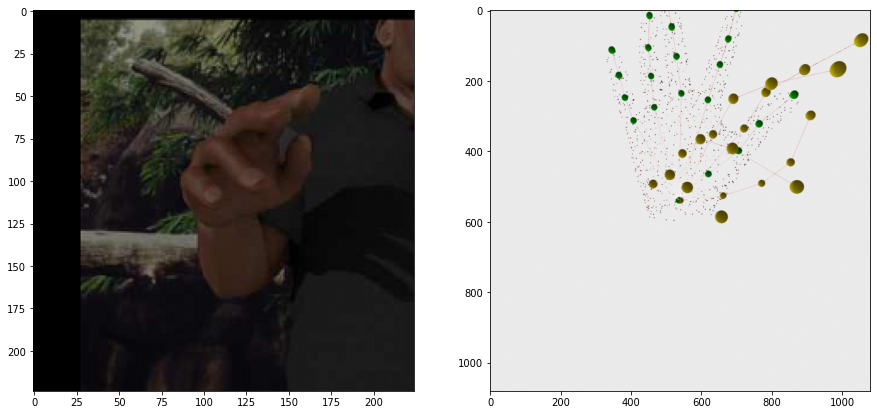

In [16]:
IMG = 46
# Run the model on image 19 of the evaluation images.
eval_image = download_image(os.path.join(gcs_path, "training", "color", "{:05d}.png".format(IMG)))
eval_image = eval_image.astype('float32')

annot_3D = y_train[IMG]
# Put the hand in the center (but only subtract in the xy dimensions). Keep the depth.
annot_3D -= np.array([annot_3D[0][0], annot_3D[0][1], 0.0], dtype=np.float32)
annot_2D = y2_train[IMG]
annot_K = k_train[IMG]

# Now we adjust the eval_image to be transformed so that the hand_root is at the center.
pixel_trans = np.array([160,160]) - annot_2D[0]
x_shift = int(pixel_trans[0])
y_shift = int(pixel_trans[1])
eval_image = np.roll(eval_image, (y_shift, x_shift), axis=(0,1) )

# black out the regions we do not care about
if y_shift > 0:
    eval_image = cv2.rectangle(eval_image, (0, 0), (320, y_shift), 0, -1)
else:
    eval_image = cv2.rectangle(eval_image, (0, 320 + y_shift), (320, 320), 0, -1)

if x_shift > 0:
    eval_image = cv2.rectangle(eval_image, (0, 0), (x_shift, 320), 0, -1)
else:
    eval_image = cv2.rectangle(eval_image, (320 + x_shift, 0), (320, 320), 0, -1)

eval_image = resize(eval_image, IMAGE_SIZE)

annot = (annot_2D, annot_3D, annot_K)
render_checkpoint_image(checkpoint_path, 0, model, eval_image, annot, template_override=False)

# MODEL EVALUATION

In [10]:
rhd_eval_dir = os.path.join(gcs_path, "evaluation", "color")

In [11]:
from evaluation import time_model
time_model(model, rhd_eval_dir, download_image)

In [12]:
from evaluation import evaluate_model
evaluate_model(model, rhd_eval_dir, download_image, y_test)

In [ ]:
from evaluation import generate_loss_graph
generate_loss_graph(checkpoint_path, model, 
    rhd_eval_dir, download_image, y_test)